In [19]:
# This script uses pickle files generated by 'TRF_decoding_pipeline.ipynb' 
# for each subject across all four frequency bands to produce the final results.

import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import eelbrain
from eelbrain import combine

In [20]:
# Initialize storage for r values by subject and band
r_values = {f'sub{i}': {'delta': [], 'theta': [], 'alpha': [], 'beta': []} 
           for i in range(1, 21)}
r_onsets_values = {f'sub{i}': {'delta': [], 'theta': [], 'alpha': [], 'beta': []} 
                  for i in range(1, 21)}

# Define exclusions (only for r, not r_onsets)
# These specific cases are excluded because they produced unreliable results with the pipeline used
exclusions = {
   'sub2': ['alpha'],
   'sub7': ['beta'],
}

# Load all files
bands = ['delta', 'theta', 'alpha', 'beta']
for sub in range(1, 21):
   for band in bands:
       filename = f'sub{sub}_{band}'
       with open(filename, 'rb') as f:
           data = pickle.load(f)
       
       # Extract r values from all trials
       for trial_key in data['trials']:
           r_onsets = data['trials'][trial_key]['r_onsets']
           r_onsets_values[f'sub{sub}'][band].append(r_onsets)
           
           # Only add r if not excluded
           if not (f'sub{sub}' in exclusions and band in exclusions[f'sub{sub}']):
               r = data['trials'][trial_key]['r']
               r_values[f'sub{sub}'][band].append(r)

# Calculate averages per band (across all subjects)
avg_r_per_band = {}
avg_r_onsets_per_band = {}

for band in bands:
   all_r_band = []
   all_r_onsets_band = []
   for sub in range(1, 21):
       all_r_band.extend(r_values[f'sub{sub}'][band])
       all_r_onsets_band.extend(r_onsets_values[f'sub{sub}'][band])
   
   avg_r_per_band[band] = np.mean(all_r_band) if all_r_band else np.nan
   avg_r_onsets_per_band[band] = np.mean(all_r_onsets_band)

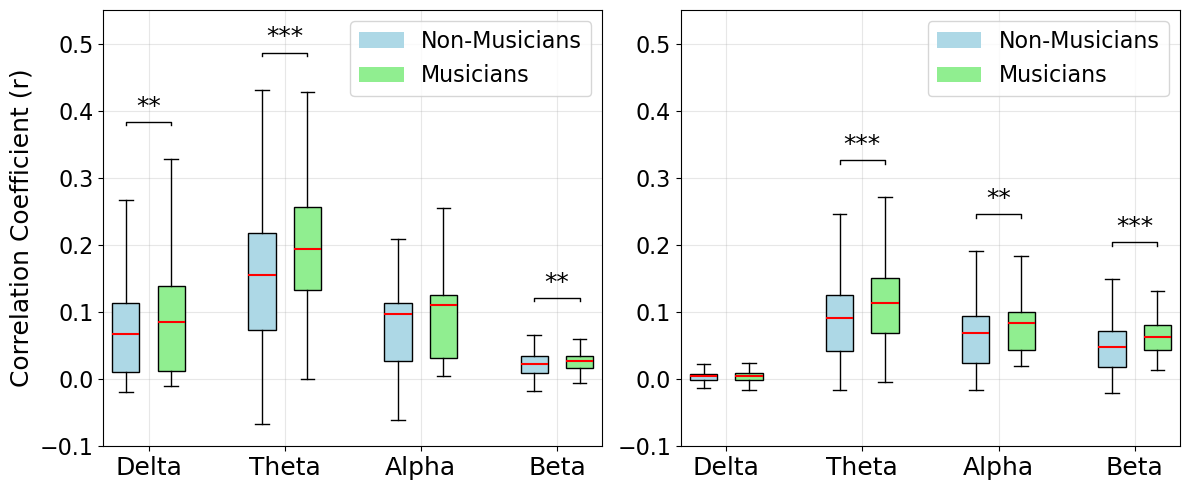

In [21]:
# Result 1

# Separate musicians and non-musicians
non_musicians = [f'sub{i}' for i in range(1, 11)]
musicians = [f'sub{i}' for i in range(11, 21)]
# Store p-values for plotting
p_values_envelope = {}
p_values_onsets = {}
# Calculate t-tests and store p-values
for band in bands:
    nm_vals = []
    m_vals = []
    for sub in non_musicians:
        nm_vals.extend(r_values[sub][band])
    for sub in musicians:
        m_vals.extend(r_values[sub][band])
    
    if nm_vals and m_vals:
        t_stat, p_value = stats.ttest_ind(nm_vals, m_vals)
        p_values_envelope[band] = p_value
    
    nm_vals = []
    m_vals = []
    for sub in non_musicians:
        nm_vals.extend(r_onsets_values[sub][band])
    for sub in musicians:
        m_vals.extend(r_onsets_values[sub][band])
    
    t_stat, p_value = stats.ttest_ind(nm_vals, m_vals)
    p_values_onsets[band] = p_value

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: r across bands - separate boxplots for each band
ax = axes[0]
for i, band in enumerate(bands):
    nm_vals = []
    m_vals = []
    for sub in non_musicians:
        nm_vals.extend(r_values[sub][band])
    for sub in musicians:
        m_vals.extend(r_values[sub][band])
    
    bp1 = ax.boxplot([nm_vals], positions=[i*3], widths=0.6, patch_artist=True, showfliers=False, medianprops=dict(visible=False))
    bp1['boxes'][0].set_facecolor('lightblue')
    ax.hlines(np.mean(nm_vals), i*3-0.3, i*3+0.3, colors='red', linewidth=1.5)
    
    bp2 = ax.boxplot([m_vals], positions=[i*3+1], widths=0.6, patch_artist=True, showfliers=False, medianprops=dict(visible=False))
    bp2['boxes'][0].set_facecolor('lightgreen')
    ax.hlines(np.mean(m_vals), i*3+1-0.3, i*3+1+0.3, colors='red', linewidth=1.5)
    
    # Add significance stars if p < 0.05
    if band in p_values_envelope and p_values_envelope[band] < 0.05:
        # Get the maximum whisker value for consistent positioning
        whisker_max_nm = bp1['whiskers'][1].get_ydata()[1]
        whisker_max_m = bp2['whiskers'][1].get_ydata()[1]
        max_whisker = max(whisker_max_nm, whisker_max_m)
        
        # Fixed offset from the highest whisker
        y_pos = max_whisker + 0.055
        
        # Draw bracket
        ax.plot([i*3, i*3, i*3+1, i*3+1], [y_pos-0.005, y_pos, y_pos, y_pos-0.005], 'k-', linewidth=1)
        
        # Add stars
        if p_values_envelope[band] < 0.001:
            stars = '***'
        elif p_values_envelope[band] < 0.01:
            stars = '**'
        else:
            stars = '*'
        ax.text(i*3+0.5, y_pos+0.005, stars, ha='center', va='bottom', fontsize=18)

ax.set_xticks([i*3+0.5 for i in range(len(bands))])
ax.set_xticklabels([band.capitalize() for band in bands], fontsize=18)
ax.set_ylabel('Correlation Coefficient (r)', fontsize=18)
ax.set_ylim(-0.1, 0.55)
ax.tick_params(axis='y', labelsize=16)
ax.grid(True, alpha=0.3)

# Add legend to first subplot
legend_elements = [Patch(facecolor='lightblue', label='Non-Musicians'),
                  Patch(facecolor='lightgreen', label='Musicians')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=16)

# Plot 2: r_onsets across bands
ax = axes[1]
for i, band in enumerate(bands):
    nm_vals = []
    m_vals = []
    for sub in non_musicians:
        nm_vals.extend(r_onsets_values[sub][band])
    for sub in musicians:
        m_vals.extend(r_onsets_values[sub][band])
    
    bp1 = ax.boxplot([nm_vals], positions=[i*3], widths=0.6, patch_artist=True, showfliers=False, medianprops=dict(visible=False))
    bp1['boxes'][0].set_facecolor('lightblue')
    ax.hlines(np.mean(nm_vals), i*3-0.3, i*3+0.3, colors='red', linewidth=1.5)
    
    bp2 = ax.boxplot([m_vals], positions=[i*3+1], widths=0.6, patch_artist=True, showfliers=False, medianprops=dict(visible=False))
    bp2['boxes'][0].set_facecolor('lightgreen')
    ax.hlines(np.mean(m_vals), i*3+1-0.3, i*3+1+0.3, colors='red', linewidth=1.5)
    
    # Add significance stars if p < 0.05
    if band in p_values_onsets and p_values_onsets[band] < 0.05:
        # Get the maximum whisker value for consistent positioning
        whisker_max_nm = bp1['whiskers'][1].get_ydata()[1]
        whisker_max_m = bp2['whiskers'][1].get_ydata()[1]
        max_whisker = max(whisker_max_nm, whisker_max_m)
        
        # Fixed offset from the highest whisker
        y_pos = max_whisker + 0.055
        
        # Draw bracket
        ax.plot([i*3, i*3, i*3+1, i*3+1], [y_pos-0.005, y_pos, y_pos, y_pos-0.005], 'k-', linewidth=1)
        
        # Add stars
        if p_values_onsets[band] < 0.001:
            stars = '***'
        elif p_values_onsets[band] < 0.01:
            stars = '**'
        else:
            stars = '*'
        ax.text(i*3+0.5, y_pos+0.005, stars, ha='center', va='bottom', fontsize=18)

ax.set_xticks([i*3+0.5 for i in range(len(bands))])
ax.set_xticklabels([band.capitalize() for band in bands], fontsize=18)
ax.set_ylim(-0.1, 0.55)
ax.tick_params(axis='y', labelsize=16)
ax.grid(True, alpha=0.3)

# Add legend to second subplot
ax.legend(handles=legend_elements, loc='upper right', fontsize=16)

plt.tight_layout()
plt.show()

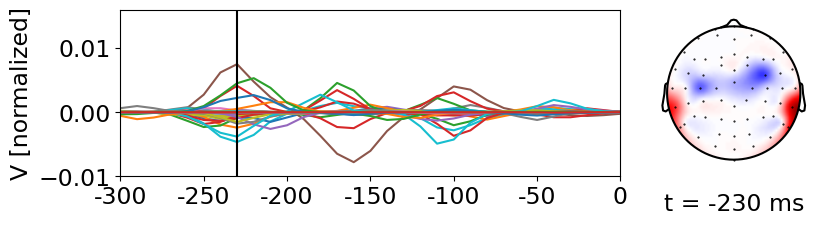

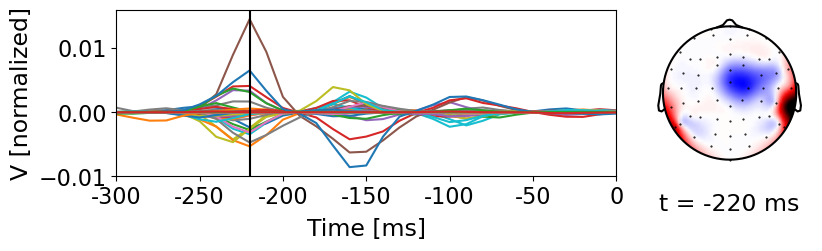

In [22]:
# Result 2

# Collect TRF decoders by band and group
musicians_trfs_by_band = {'delta': [], 'theta': [], 'alpha': [], 'beta': []}
non_musicians_trfs_by_band = {'delta': [], 'theta': [], 'alpha': [], 'beta': []}

# Load decoders from files
for sub in range(1, 21):
    for band in bands:
        filename = f'sub{sub}_{band}'
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        # Get the decoder
        decoder = data['decoder']
        
        # Separate by group
        if sub <= 10:  # Non-musicians
            non_musicians_trfs_by_band[band].append(decoder.h)
        else:  # Musicians
            musicians_trfs_by_band[band].append(decoder.h)

# Plot only for theta band
band = 'theta'

# Non-musicians
combined_nm = combine(non_musicians_trfs_by_band[band])
trf_avg_nm = combined_nm.mean('case')
t_nm = trf_avg_nm.std('sensor').argmax('time')

# Musicians
combined_m = combine(musicians_trfs_by_band[band])
trf_avg_m = combined_m.mean('case')
t_m = trf_avg_m.std('sensor').argmax('time')

# Find the maximum absolute value across both groups for consistent scaling
max_val = max(abs(trf_avg_nm).max(), abs(trf_avg_m).max())

# Plot with consistent vmax/vmin
p_nm = eelbrain.plot.TopoButterfly(trf_avg_nm, t=t_nm, w=7.5, h=2.5, clip='circle', 
                                   vmax=max_val, vmin=-max_val, xlim=(-0.300, 0.000))
p_nm.set_ylim(-0.010, 0.016)

# Set font sizes for non-musicians plot
for ax in p_nm.axes:
    ax.tick_params(axis='both', labelsize=17)
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_ylabel('V [normalized]', fontsize=17)
    # Set font size for the t= text
    for text in ax.texts:
        text.set_fontsize(17)

# Musicians with same scaling
p_m = eelbrain.plot.TopoButterfly(trf_avg_m, t=t_m, w=7.5, h=2.5, clip='circle',
                                  vmax=max_val, vmin=-max_val, xlim=(-0.300, 0.000))
p_m.set_ylim(-0.010, 0.016)

# Set font sizes for musicians plot
for ax in p_m.axes:
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Time [ms]', fontsize=17)
    ax.xaxis.set_label_coords(0.5, -0.25)  # Move x-axis label down more
    ax.set_ylabel('V [normalized]', fontsize=17)
    # Set font size for the t= text
    for text in ax.texts:
        text.set_fontsize(17)

# Move head plots to the right
# For non-musicians
for i, ax in enumerate(p_nm.axes):
    if i > 0:  # Skip the butterfly plot (first axis)
        pos = ax.get_position()
        ax.set_position([pos.x0 + 0.04, pos.y0, pos.width, pos.height])

# For musicians  
for i, ax in enumerate(p_m.axes):
    if i > 0:  # Skip the butterfly plot (first axis)
        pos = ax.get_position()
        ax.set_position([pos.x0 + 0.04, pos.y0, pos.width, pos.height])

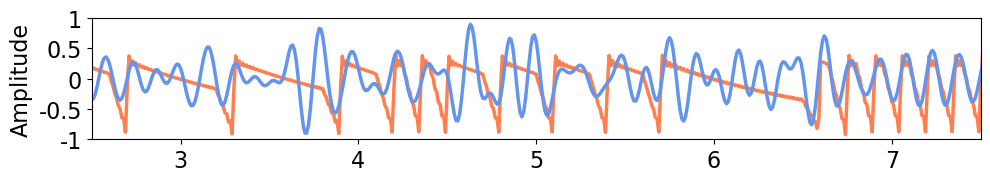

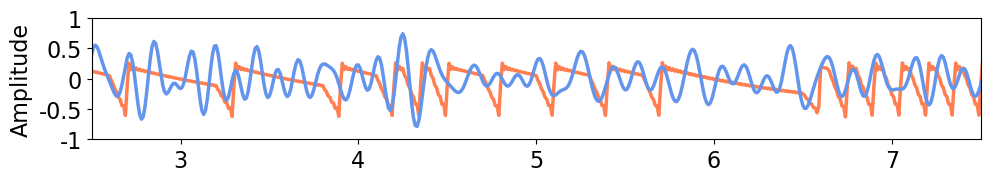

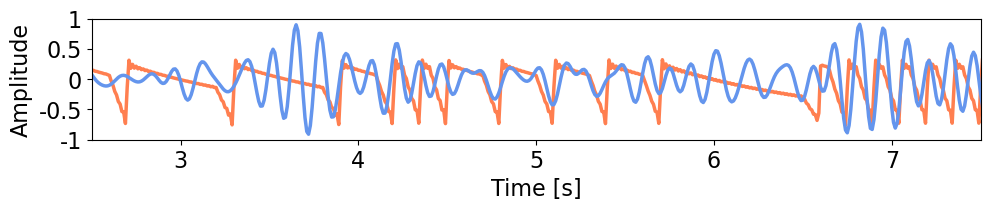

In [23]:
# Result 3


# Find top 5 trials for theta band only
band = 'theta'
top5_envelope_theta = []
top5_onsets_theta = []
# Collect all trials with their r values for theta
all_envelope_trials = []
all_onsets_trials = []
for sub in range(1, 21):
    filename = f'sub{sub}_{band}'
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    trial_keys = list(data['trials'].keys())
    
    # Collect envelope trials
    if r_values[f'sub{sub}'][band]:
        for idx, r_val in enumerate(r_values[f'sub{sub}'][band]):
            trial_num = trial_keys[idx].replace('trial', '')
            all_envelope_trials.append({
                'subject': sub,
                'trial': trial_num,
                'r': r_val,
                'data': data['trials'][trial_keys[idx]]
            })
    
    # Collect onsets trials
    if r_onsets_values[f'sub{sub}'][band]:
        for idx, r_onsets_val in enumerate(r_onsets_values[f'sub{sub}'][band]):
            trial_num = trial_keys[idx].replace('trial', '')
            all_onsets_trials.append({
                'subject': sub,
                'trial': trial_num,
                'r': r_onsets_val,
                'data': data['trials'][trial_keys[idx]]
            })
# Sort and get top 5
all_envelope_trials.sort(key=lambda x: x['r'], reverse=True)
all_onsets_trials.sort(key=lambda x: x['r'], reverse=True)
top5_envelope_theta = all_envelope_trials[:5]
top5_onsets_theta = all_onsets_trials[:5]


# ENVELOPE PLOTS (BEST TO WORST)


# Best exmple used in the paper

# Plot only the 5th-best envelope trial, as it provides the clearest visual example
info = top5_envelope_theta[4]  # Index 4 is the 5th item
trial_data = info['data']
y = trial_data['y']
y_pred = trial_data['y_pred']

# Find max between both signals and use same scaling factor
max_abs = max(np.abs(y.x).max(), np.abs(y_pred.x).max())
scale_factor = 1.75 / max_abs
y = y * scale_factor
y_pred = y_pred * scale_factor

y.name = 'Envelope'
y_pred.name = 'Predicted'
r = info['r']
p = eelbrain.plot.UTS([[y, y_pred]], w=10, h=2, xlim=(2.5, 7.5), legend=False)
# Change colors and make lines thicker
p.axes[0].lines[0].set_color('coral')
p.axes[0].lines[1].set_color('cornflowerblue')
for line in p.axes[0].lines:
    line.set_linewidth(2.5)
    
for ax in p.axes:
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('Amplitude', fontsize=16)
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_yticklabels(['-1', '-0.5', '0', '0.5', '1'])
    ax.set_ylim(-1.0, 1.0)


# Average exmple used in the paper
# Find the envelope trial for the theta band whose correlation is closest to the mean r-value 
# Only consider trials 1, 11, or 21 (all corresponding to the second melody)
# The melody matches the one used in the best example for the best visualization

band = 'theta'
# Get the mean r value for theta band envelope
target_r = avg_r_per_band[band]
min_diff_r = float('inf')
closest_env_specific_info = None
allowed_trials = ['1', '11', '21']

for sub in range(1, 21):
    filename = f'sub{sub}_{band}'
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    trial_keys = list(data['trials'].keys())
    
    # Check envelope trials - only for specific trial numbers
    if r_values[f'sub{sub}'][band] and not np.isnan(target_r):
        for idx, r_val in enumerate(r_values[f'sub{sub}'][band]):
            trial_num = trial_keys[idx].replace('trial', '')
            
            # Only consider trials 1, 11, or 21
            if trial_num in allowed_trials:
                diff = abs(r_val - target_r)
                
                if diff < min_diff_r:
                    min_diff_r = diff
                    closest_env_specific_info = {
                        'subject': sub,
                        'trial': trial_num,
                        'data': data['trials'][trial_keys[idx]],
                        'mean_r': target_r,
                        'r': r_val
                    }

# Plot envelope trial closest to mean (from trials 1, 11, or 21 only)
if closest_env_specific_info:
    info = closest_env_specific_info
    trial_data = info['data']
    y = trial_data['y']
    y_pred = trial_data['y_pred']
    
    # Find max between both signals and use same scaling factor
    max_abs = max(np.abs(y.x).max(), np.abs(y_pred.x).max())
    scale_factor = 1.45 / max_abs
    y = y * scale_factor
    y_pred = y_pred * scale_factor
    
    y.name = 'Envelope'
    y_pred.name = 'Predicted'
    r = trial_data['r']
    p = eelbrain.plot.UTS([[y, y_pred]], w=10, h=2, xlim=(2.5, 7.5), legend=False)
    # Change colors and make lines thicker
    p.axes[0].lines[0].set_color('coral')
    p.axes[0].lines[1].set_color('cornflowerblue')
    for line in p.axes[0].lines:
        line.set_linewidth(2.5)

    for ax in p.axes:
        ax.tick_params(axis='both', labelsize=16)
        ax.set_xlabel('', fontsize=16)
        ax.set_ylabel('Amplitude', fontsize=16)
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.set_yticklabels(['-1', '-0.5', '0', '0.5', '1'])
        ax.set_ylim(-1.0, 1.0)


# Worst exmple used in the paper
# Find worst envelope trial for theta band - only trials 1, 11, or 21
band = 'theta'
min_r = 1
worst_env_specific_info = None
allowed_trials = ['1', '11', '21']

for sub in range(1, 21):
    filename = f'sub{sub}_{band}'
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    trial_keys = list(data['trials'].keys())
    
    # Check envelope trials - only for specific trial numbers
    if r_values[f'sub{sub}'][band]:
        for idx, r_val in enumerate(r_values[f'sub{sub}'][band]):
            trial_num = trial_keys[idx].replace('trial', '')
            
            # Only consider trials 1, 11, or 21
            if trial_num in allowed_trials:
                if r_val < min_r:
                    min_r = r_val
                    worst_env_specific_info = {
                        'subject': sub,
                        'trial': trial_num,
                        'data': data['trials'][trial_keys[idx]],
                        'r': r_val
                    }

# Plot worst envelope trial (from trials 1, 11, or 21 only)
if worst_env_specific_info:
    info = worst_env_specific_info
    trial_data = info['data']
    y = trial_data['y']
    y_pred = trial_data['y_pred']
    
    # Find max between both signals and use same scaling factor
    max_abs = max(np.abs(y.x).max(), np.abs(y_pred.x).max())
    scale_factor = 6 / max_abs
    y = y * scale_factor
    y_pred = y_pred * scale_factor
    
    y.name = 'Envelope'
    y_pred.name = 'Predicted'
    r = trial_data['r']
    
    p = eelbrain.plot.UTS([[y, y_pred]], w=10, h=2, xlim=(2.5, 7.5), legend=False)
    # Change colors and make lines thicker
    p.axes[0].lines[0].set_color('coral')
    p.axes[0].lines[1].set_color('cornflowerblue')
    for line in p.axes[0].lines:
        line.set_linewidth(2.5)
        
    for ax in p.axes:
        ax.tick_params(axis='both', labelsize=16)
        ax.set_ylabel('Amplitude', fontsize=16)
        ax.set_xlabel('Time [s]', fontsize=16)
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.set_yticklabels(['-1', '-0.5', '0', '0.5', '1'])
        ax.set_ylim(-1.0, 1.0)

In [24]:
# Print subject, trial, and r values for all plots
print("ENVELOPE PLOTS:")
print("-" * 50)
print(f"Best used in the paper:    Subject {top5_envelope_theta[4]['subject']}, Trial {top5_envelope_theta[4]['trial']}, r = {top5_envelope_theta[4]['r']:.3f}")
print(f"Mean used in the paper: Subject {closest_env_specific_info['subject']}, Trial {closest_env_specific_info['trial']}, r = {closest_env_specific_info['r']:.3f}")
print(f"Worst used in the paper: Subject {worst_env_specific_info['subject']}, Trial {worst_env_specific_info['trial']}, r = {worst_env_specific_info['r']:.3f}")

ENVELOPE PLOTS:
--------------------------------------------------
Best used in the paper:    Subject 16, Trial 1, r = 0.427
Mean used in the paper: Subject 6, Trial 1, r = 0.171
Worst used in the paper: Subject 7, Trial 21, r = -0.018
